# Satellite Imagery

In [1]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes

  Using cached geojson-2.5.0-py2.py3-none-any.whl (14 kB)
     |████████████████████████████████| 93 kB 56 kB/s  eta 0:00:011
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-_ixuruxe
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-_ixuruxe
  Created wheel for geopandas: filename=geopandas-0.7.0+68.gc5d48ec-py2.py3-none-any.whl size=957871 sha256=418ca12ce7243af27b1095c1cf4d75859073159312fc9954af69ed782c94bb3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sppmac_t/wheels/e7/83/8b/b0820f79d4683dc1af4f6f664cbef2c55c612647f22abee7bc
Successfully built geopandas
  Attempting

In [2]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona


Bad key "text.kerning_factor" on line 4 in
/home/vikrant/anaconda3/envs/eo/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


#### We can create an account on Copernicus Open Access Hub and play with the data

In [3]:
user = '' 
password = '' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

#### We shall take the necessary shape files of Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano. We shall work on this.

In [4]:
!wget https://www.dropbox.com/s/ymxuxpcnj88mlz2/NReserve.zip

--2020-05-29 00:49:05--  https://www.dropbox.com/s/ymxuxpcnj88mlz2/NReserve.zip
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6024:1::a27d:4401, 162.125.68.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6024:1::a27d:4401|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ymxuxpcnj88mlz2/NReserve.zip [following]
--2020-05-29 00:49:08--  https://www.dropbox.com/s/raw/ymxuxpcnj88mlz2/NReserve.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14846f2dffa21b79c5dfb0e598.dl.dropboxusercontent.com/cd/0/inline/A4mGcGwE8PNga66eBrdqf_rlBO5CMqTGzxR4Znz7BZDUr-kXLP_6D61Gpm9mUjZfvxMVEwsmqca-VTgpyK_zH7qAKcX_ap9Z-YN-Mfrl1Dph2Q/file# [following]
--2020-05-29 00:49:09--  https://uc14846f2dffa21b79c5dfb0e598.dl.dropboxusercontent.com/cd/0/inline/A4mGcGwE8PNga66eBrdqf_rlBO5CMqTGzxR4Znz7BZDUr-kXLP_6D61Gpm9mUjZfvxMVEwsmqca-VTgpyK_zH7qAKcX_ap9Z-YN-Mfrl1Dph2Q/file


In [5]:
!unzip 'NReserve.zip'

Archive:  NReserve.zip
   creating: NReserve/
 extracting: NReserve/NaturalReserve_Polygon.cpg  
  inflating: NReserve/NaturalReserve_Polygon.dbf  
  inflating: NReserve/NaturalReserve_Polygon.prj  
  inflating: NReserve/NaturalReserve_Polygon.qpj  
  inflating: NReserve/NaturalReserve_Polygon.shp  
  inflating: NReserve/NaturalReserve_Polygon.shx  


In [6]:
nReserve = gpd.read_file('NReserve/NaturalReserve_Polygon.shp')
nReserve

,id,geometry
0,None,"POLYGON ((12.34697 41.70233, 12.37470 41.71808..."


In [7]:
m = folium.Map([41.7023292727353, 12.34697305914639], zoom_start=11)

folium.GeoJson(nReserve).add_to(m)
m

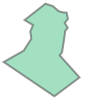

In [8]:
footprint = None
for i in nReserve['geometry']:
    footprint = i
    
footprint

In [9]:
products = api.query(footprint,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))

In [10]:
len(products)

6

In [11]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

/home/vikrant/anaconda3/envs/eo/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 21:54:46.895,11731,122,...,02.12,Level-2A,S2MSI2A,Sentinel-2,1006.25 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,16e95baf-bbcb-43fe-ab67-5fecea2ffde5,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
590a4ce9-c540-4cb9-844b-3ee1efff8ca9,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 22:16:12.999,11731,122,...,02.12,Level-2A,S2MSI2A,Sentinel-2,1009.58 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,590a4ce9-c540-4cb9-844b-3ee1efff8ca9,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
d1a70889-1d44-414c-a357-08a7185c04b4,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:50:05.133,12017,122,...,02.12,Level-2A,S2MSI2A,Sentinel-2,941.03 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,d1a70889-1d44-414c-a357-08a7185c04b4,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:48:59.153,12017,122,...,02.12,Level-2A,S2MSI2A,Sentinel-2,948.75 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
c9e76145-3270-458c-9927-49d1354be29e,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-20T10:00:31.024Z, Instrument: MS...",2019-06-20 10:00:31.024,2019-06-20 10:00:31.024,2019-06-20 22:10:21.392,20854,122,...,02.12,Level-2A,S2MSI2A,Sentinel-2,967.74 MB,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,S2A_OPER_MSI_L1C_TL_MPS__20190620T121338_A0208...,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,c9e76145-3270-458c-9927-49d1354be29e,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
3155fa67-c0d6-4c0f-a556-f5e0ee532c9d,S2A_MSIL2A_20190620T100031_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-20T10:00:31.024Z, Instrument: MS...",2019-06-20 10:00:31.024,2019-06-20 10:00:31.024,2019-06-20 22:03:54.767,20854,122,...,02.12,Level-2A,S2MSI2A,Sentinel-2,961.06 MB,S2A_MSIL2A_20190620T100031_N0212_R122_T33TTG_2

In [13]:
api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

Downloading: 100%|██████████| 1.06G/1.06G [15:20<00:00, 1.15MB/s]
MD5 checksumming: 100%|██████████| 1.06G/1.06G [00:01<00:00, 674MB/s]


{'id': '16e95baf-bbcb-43fe-ab67-5fecea2ffde5',
 'title': 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319',
 'size': 1055191497,
 'md5': 'CE4FBC92040E79591C7380F7B159B5C3',
 'date': datetime.datetime(2019, 6, 5, 10, 0, 39, 24000),
 'footprint': 'POLYGON((11.354954233772318 42.39470139413761,12.687592758603905 42.42936087235922,12.723033432665233 41.441212166985935,11.410731332148327 41.407726190110715,11.354954233772318 42.39470139413761))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('16e95baf-bbcb-43fe-ab67-5fecea2ffde5')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2019, 6, 5, 21, 55, 17, 343000),
 'Ingestion Date': datetime.datetime(2019, 6, 5, 21, 54, 46, 895000),
 'path': './S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip',
 'downloaded_bytes': 1039462857}

### Satellite Imagery with Rasterio

In [14]:
!unzip S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip --quite

Archive:  S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip
caution: filename not matched:  --quite


In [15]:
!unzip S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip 

Archive:  S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.zip
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/INSPIRE.xml  
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_PDI_Level-2A_Tile_Metadata.xsd  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_PDI_Level-2A_Datastrip_Metadata.xsd  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/rep_info/S2_User_Product_Level-2A_Metadata.xsd  
   creating: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/star_bg.jpg  
 extracting: S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/HTML/banner_1.png  


In [16]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'

b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')

In [17]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

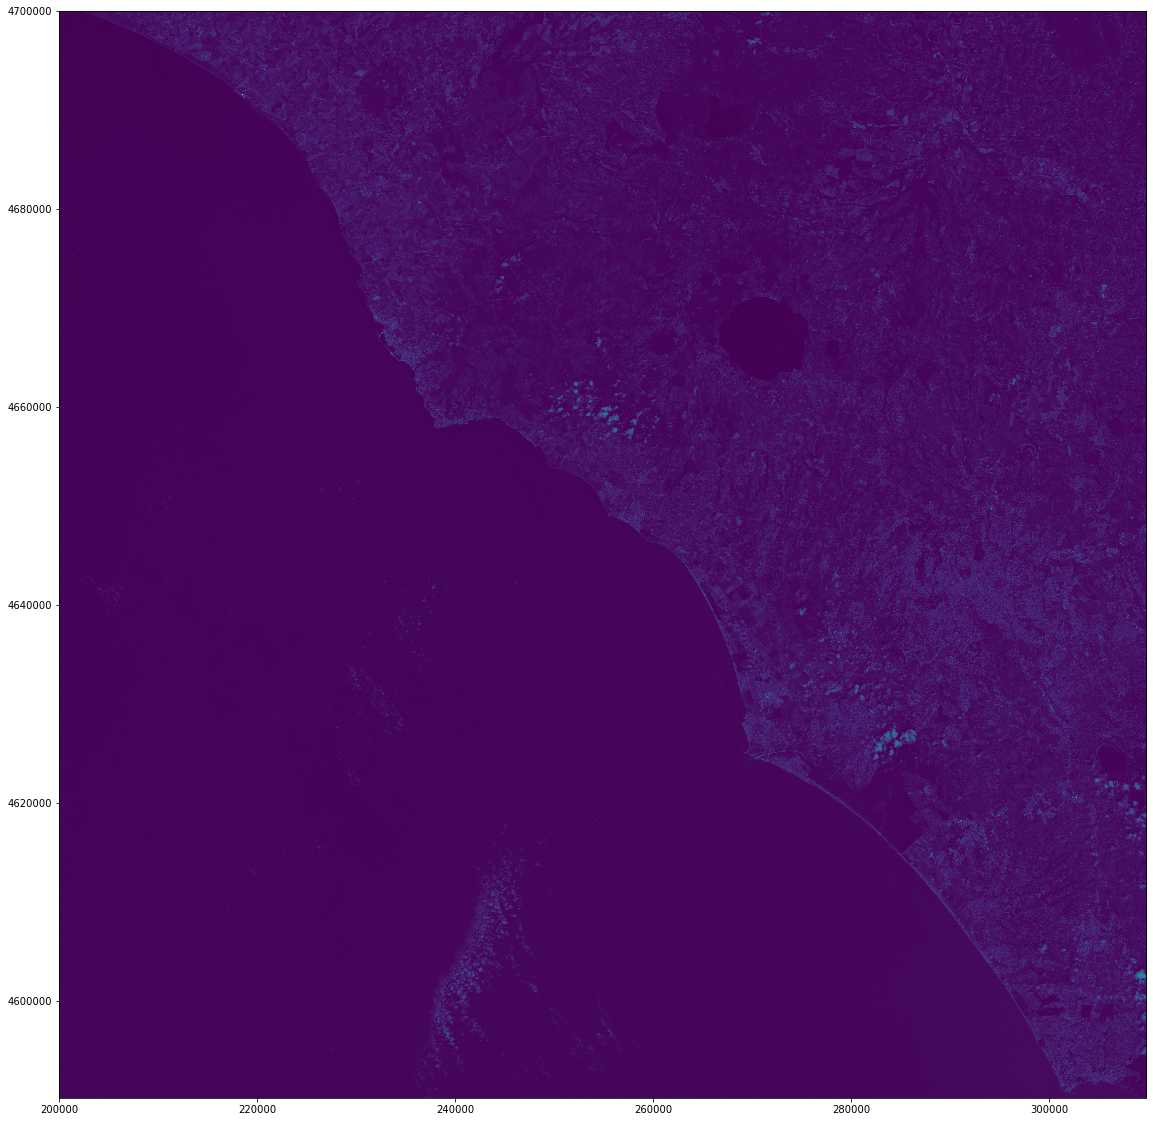

In [18]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax)
plt.show()

In [19]:
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

#### Masking satellite Images

In [20]:
#src = rio.open(r"RGB.tiff")
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/home/vikrant/anaconda3/envs/eo/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


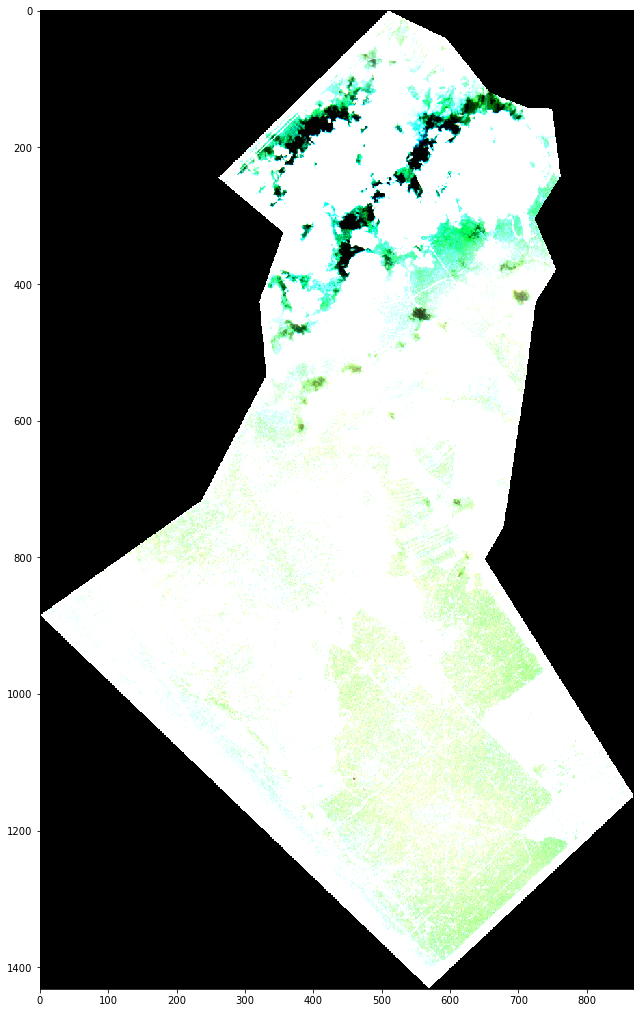

<function matplotlib.pyplot.show(*args, **kw)>

In [21]:
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

In [22]:
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b8 = rio.open(R10+'/T33TTG_20190605T100039_B08_10m.jp2')

In [23]:
red = b4.read()
nir = b8.read()

In [24]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

In [25]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))